# BI-PRS: semestrální projekt 3

Cílem třetího semestrálního projektu je analýza hrubého domácího produktu evropských zemí. Zaměříme se na srovnání HDP různých evropských zemí v nějakém konkrétním roce a identifikujeme trendy a vzory ve vývoji jejich ekonomik. Dále se pokusíme porozumět faktorům, které ovlivňují rozdíly v HDP mezi jednotlivými zeměmi a jakým způsobem politické, sociální a ekonomické faktory formují ekonomickou prosperitu Evropy. Naše analýza by měla poskytnout ucelený pohled na ekonomickou situaci a trendy v Evropě a sloužit jako základ pro diskusi o možných politikách a opatřeních pro podporu ekonomického růstu a prosperity v regionu.

Náš tým se skládá ze tří lidí: Ruslana Orazbekova (orazbrus), Nelly Shikina (shikinel), Daria Sychova (sychodar). Nejprve zjistíme, pro který rok budeme data zkoumat pomocí známého vzorce. Reprezentatntem ve třetím semestrálním projektu je Nelly Shikina.


In [266]:
# K = den narození reprezentanta skupiny (1-31)
# L = počet písmen v příjmení reprezentanta
# M = ((K+L)×47)mod11+1

K <- 16
L <- nchar('Shikina')
M <- ((K + L) * 47) %% 11 + 1
print(M)
print(2011 + M)

[1] 4
[1] 2015


Uvažujeme tedy data z roku 2015.

Nejdříve načteme potřebné knihovny a požadovaný dataset.

In [267]:
library(eurostat)
library(tidyverse)
library(dplyr)
library(ggplot2)
library(lmtest)
library(car)

In [268]:
# Retrieving GDP data at market prices in euro per capita
data <- get_eurostat("nama_10_pc", time_format = "num", filters = list(na_item = "B1GQ", unit = "CP_EUR_HAB", time = 2015))

# Display the first rows of data for checking
head(data)

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\Nelly\AppData\Local\Temp\RtmpGqcgoB/eurostat/8e0c9884893cac1136cea0b1301f4747.rds

Table  nama_10_pc  read from cache file:  C:\Users\Nelly\AppData\Local\Temp\RtmpGqcgoB/eurostat/8e0c9884893cac1136cea0b1301f4747.rds



freq,unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
A,CP_EUR_HAB,B1GQ,EU27_2020,2015,27500
A,CP_EUR_HAB,B1GQ,EU28,2015,29180
A,CP_EUR_HAB,B1GQ,EU15,2015,33810
A,CP_EUR_HAB,B1GQ,EA,2015,31080
A,CP_EUR_HAB,B1GQ,EA20,2015,30830
A,CP_EUR_HAB,B1GQ,EA19,2015,31080


Prozkoumejme, co znamenají jednotlivé sloupce datsetu.

1. **freq**: Tento sloupec udává frekvenci, s jakou jsou data zaznamenána. V tomto případě je to "A", což znamená, že data jsou roční.

2. **unit**: Sloupec `unit` označuje jednotku, v níž jsou hodnoty udávány. Zde je uvedeno "CP_EUR_HAB", což znamená "current prices, euros per inhabitant", tedy hodnoty jsou vyjádřeny v eurech na obyvatele.

3. **na_item**: Tento sloupec označuje položku Národních účtů podle zvoleného kritéria.

4. **geo**: Sloupec `geo` označuje geografickou oblast, pro kterou jsou hodnoty uvedeny.

5. **time**: Tento sloupec obsahuje rok, ke kterému se údaje vztahují.

6. **values**: Sloupec `values` obsahuje samotné hodnoty HDP vyjádřené v eurech na obyvatele pro danou oblast (země/region) a rok.

In [269]:
# Label the data with label_eurostat
data <- label_eurostat(data)
head(data)

freq,unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 27 countries (from 2020),2015,27500
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 28 countries (2013-2020),2015,29180
Annual,"Current prices, euro per capita",Gross domestic product at market prices,European Union - 15 countries (1995-2004),2015,33810
Annual,"Current prices, euro per capita",Gross domestic product at market prices,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)",2015,31080
Annual,"Current prices, euro per capita",Gross domestic product at market prices,Euro area – 20 countries (from 2023),2015,30830
Annual,"Current prices, euro per capita",Gross domestic product at market prices,Euro area - 19 countries (2015-2022),2015,31080


Je vidět, že dataset obsahuje redundantní sloupce, takže než přejdeme k úkolům samotným, data trochu upravíme. Zbavíme se některých sloupců.

In [270]:
# Drop unnecessary columns
data <- subset(data, select = c("geo", "values"))
head(data)

geo,values
<chr>,<int>
European Union - 27 countries (from 2020),27500
European Union - 28 countries (2013-2020),29180
European Union - 15 countries (1995-2004),33810
"Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015, EA20-2023)",31080
Euro area – 20 countries (from 2023),30830
Euro area - 19 countries (2015-2022),31080


In [271]:
# Checking if we have NaN values
any_na <- any(is.na(data))
print(any_na)

[1] TRUE


Náš dataset má NA hodnoty. Podívejme se, kde přesně nám chybí data.

In [272]:
# Identifying missing values
missing_values <- is.na(data)

# Display rows with missing values
rows_with_missing <- data[apply(missing_values, 1, any), ]
print(rows_with_missing)

# A tibble: 2 × 2
  geo                    values
  <chr>                   <int>
1 Bosnia and Herzegovina     NA
2 Kosovo*                    NA


Chybějící hodnoty jsou identifikovány v zemích "Bosnia and Herzegovina" a "Kosovo*". Hodnoty HDP pro tyto země v roce 2015 chybí (označeny jako NA).

In [273]:
# Identifying neighboring countries for Bosnia and Herzegovina and Kosovo
neighbors_BiH <- c("Croatia", "Serbia", "Montenegro")
neighbors_Kosovo <- c("Albania", "North Macedonia", "Serbia")

# Selecting data for neighboring countries
data_neighbors_BiH <- subset(data, geo %in% neighbors_BiH)
data_neighbors_Kosovo <- subset(data, geo %in% neighbors_Kosovo)

# Calculating the average GDP of neighboring countries
mean_BiH <- mean(data_neighbors_BiH$values, na.rm = TRUE)
mean_Kosovo <- mean(data_neighbors_Kosovo$values, na.rm = TRUE)

# Replacing missing values with the averages of neighboring countries
data$values[data$geo == "Bosnia and Herzegovina" & is.na(data$values)] <- mean_BiH
data$values[data$geo == "Kosovo*" & is.na(data$values)] <- mean_Kosovo

# Displaying the modified data
print(data[data$geo %in% c("Bosnia and Herzegovina", "Kosovo*"), ])

# A tibble: 2 × 2
  geo                    values
  <chr>                   <dbl>
1 Bosnia and Herzegovina  7240 
2 Kosovo*                 4447.


Tímto způsobem jsme nahradily chybějící hodnoty průměrným HDP sousedních zemí.

In [274]:
# Checking if we have NaN values
any_na <- any(is.na(data))
print(any_na)

[1] FALSE


Data jsou v pořádku. Pojďme na ty úlohy.

## ✭ Úloha 1

Krátce prezentujeme rozdělení HDP a jeho charakteristiky číselně i graficky. Probereme si, jaké údaje o jednotlivých zemích mohou mít vliv na HDP.

In [275]:
# Basic GDP characteristics
summary(data$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3560   11702   25355   29899   38190  148440 

Tyto číselné charakteristiky poskytují užitečné informace o rozdělení HDP v evropských zemích v roce 2015:

- **Minimální hodnota**: Nejnižší hodnota HDP v eurech na obyvatele z celého souboru je 3560. To ukazuje na nejmenší úroveň ekonomické prosperity mezi zkoumanými zeměmi.

- **První kvartil (1st Qu.)**: Hodnota, pod kterou spadá první čtvrtina dat, je 11702 eur na obyvatele. To znamená, že 25 % zemí má HDP nižší než tato hodnota.

- **Medián**: Medián, což je střední hodnota datového souboru, je 25355 eur na obyvatele. To znamená, že polovina zemí má HDP nižší než tento medián a polovina má vyšší.

- **Průměr (Mean)**: Průměrná hodnota HDP v evropských zemích v roce 2015 je 29879 eur na obyvatele. To je aritmetický průměr všech hodnot HDP.

- **Třetí kvartil (3rd Qu.)**: Hodnota, pod kterou spadá třetí čtvrtina dat, je 38190 eur na obyvatele. To znamená, že 75 % zemí má HDP nižší než tato hodnota.

- **Maximální hodnota**: Nejvyšší hodnota HDP v eurech na obyvatele z celého souboru je 148440. Jedná se o nejvyšší úroveň ekonomické prosperity mezi zkoumanými zeměmi.

Tyto statistické údaje nám poskytují přehled o rozdělení HDP a jeho variabilitě mezi evropskými zeměmi v roce 2015. Pro přehlednost nyní vykreslíme histogram rozdělení HDP v roce 2015.

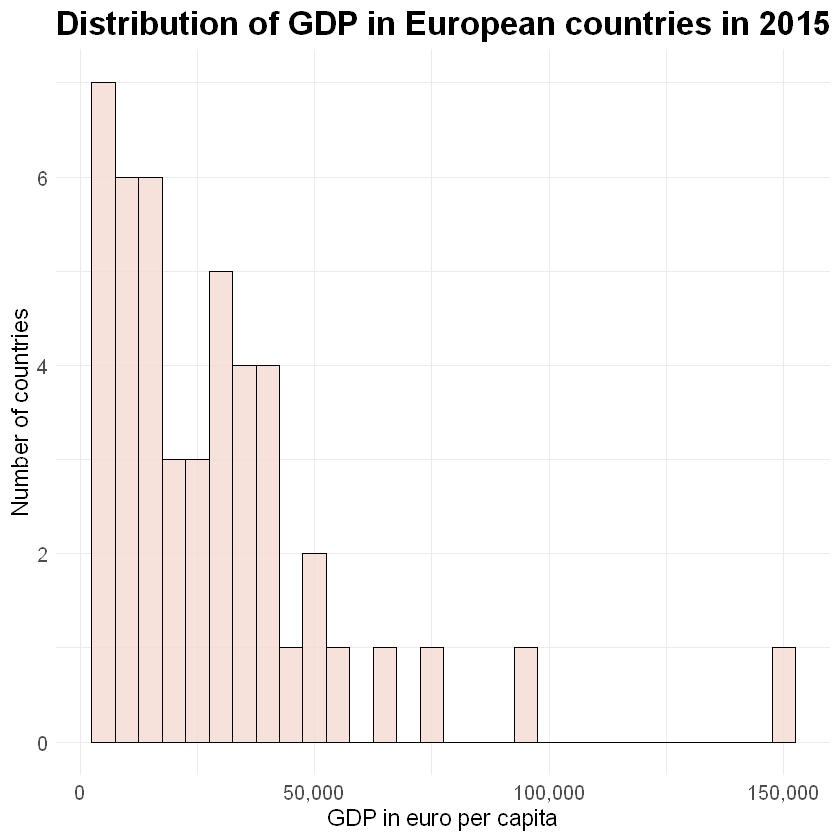

In [276]:
# Histogram
ggplot(data, aes(x = values)) +
  geom_histogram(binwidth = 5000, fill = "#F5DAD2", color = "black", alpha = 0.8) +  # Alpha channel for clarity
  labs(title = "Distribution of GDP in European countries in 2015",
       x = "GDP in euro per capita",
       y = "Number of countries") +
  scale_x_continuous(labels = scales::comma) +  # Adding thousands separators to the x-axis
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),  # Caption size and style
        axis.text = element_text(size = 12),  # Text size on axes
        axis.title = element_text(size = 14))  # Size of axis labels

Tento histogram zobrazuje rozdělení hrubého domácího produktu (HDP) v evropských zemích v roce 2015. Na osu x je uvedeno HDP v eurech na obyvatele a na osu y počet zemí, které dosáhly dané úrovně HDP.

Graf ukazuje, že většina zemí má HDP mezi 10 000 a 50 000 eur na obyvatele. Existuje také menší počet zemí s HDP nad 50 000 eur na obyvatele, což může zahrnovat země s vyššími úrovněmi ekonomické prosperity.

Různé faktory mohou ovlivňovat HDP zemí. Některé z hlavních faktorů zahrnují:

* **Ekonomická politika**: Makroekonomická politika vlád, včetně monetární politiky a fiskální politiky, může mít vliv na HDP.

* **Obchodní politika**: Otevřenost země obchodu s ostatními zeměmi může ovlivnit HDP prostřednictvím exportu a importu zboží a služeb.

* **Technologický pokrok**: Inovace a technologický pokrok mohou zvyšovat produktivitu a stimulovat růst HDP.

* **Pracovní trh**: Zaměstnanost, úroveň mezd a pracovní podmínky mohou ovlivnit schopnost země generovat HDP.

* **Infrastruktura**: Kvalita infrastruktury, včetně dopravních sítí a telekomunikací, může mít vliv na efektivitu ekonomiky a tím i na HDP.

* **Politická stabilita**: Politická stabilita a právní rámec mohou ovlivnit investice a obchod, což může mít vliv na HDP.

Nyní můžeme pokračovat úlohou 2.

## ✭ Úloha 2

Rozhodly jsme se přidat další [dataset](https://www.kaggle.com/datasets/nelgiriyewithana/countries-of-the-world-2023) s informacemi o různých zemích, včetně evropských zemí z našeho projektu.

> This comprehensive dataset provides a wealth of information about all countries worldwide, covering a wide range of indicators and attributes. It encompasses demographic statistics, economic indicators, environmental factors, healthcare metrics, education statistics, and much more. With every country represented, this dataset offers a complete global perspective on various aspects of nations, enabling in-depth analyses and cross-country comparisons.

Pro zkoumané země můžeme jako regresory zvolit následující čtyři příznaky:

1. **Průměrný věk obyvatelstva**: tato numerická proměnná může poskytnout informace o demografické struktuře země a jejím vlivu na ekonomiku, jako je například pracovní síla a spotřeba.

2. **Hustota zalidnění**: další numerická proměnná, která může ovlivnit HDP, je hustota zalidnění. Vyšší hustota obvykle znamená větší ekonomickou aktivitu a přístup k většímu trhu.

3. **Jazyk**: tato kategoriální proměnná může být užitečná pro rozlišení mezi zeměmi na základě oficiálního nebo dominantního jazyka. Země se shodným jazykem mohou mít lepší obchodní vztahy a komunikaci, což může mít pozitivní vliv na ekonomiku a cestovní ruch.

4. **Měna**: další kategoriální proměnná, která může být důležitá, je měna, kterou země používá. Země používající euro mohou mít výhodu v obchodě a stabilitě měny ve srovnání s zeměmi, které používají jiné měny.

Nyní bychom mohly použít regresní analýzu k určení vztahu mezi těmito proměnnými a HDP (např. pomocí lineární regrese).

Chceme získat data o průměrném věku obyvatelstva z Eurostatu pro rok 2015 s pomocí identifikátoru MEDAGEPOP pro střední věk obyvatelstva. Vytvoříme dotaz do databáze Eurostatu, abychom mohly získat požadovaná data.

#### ✦ Průměrný věk a hustota zalidnění

In [277]:
# Data query on the average age of the population in 2019
data_age <- get_eurostat("eq_pop04", filters = list(time="2015", indic_de = "MEDAGEPOP"))

# Displaying first rows of data
head(data_age)

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\Nelly\AppData\Local\Temp\RtmpGqcgoB/eurostat/a2cb954d105b1c38f2e5b96f745df4fb.rds

Table  eq_pop04  read from cache file:  C:\Users\Nelly\AppData\Local\Temp\RtmpGqcgoB/eurostat/a2cb954d105b1c38f2e5b96f745df4fb.rds



freq,indic_de,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,MEDAGEPOP,EU27_2020,2015-01-01,42.7
A,MEDAGEPOP,EA20,2015-01-01,NA
A,MEDAGEPOP,EA19,2015-01-01,43.3
A,MEDAGEPOP,BE,2015-01-01,41.4
A,MEDAGEPOP,BG,2015-01-01,43.4
A,MEDAGEPOP,CZ,2015-01-01,41.1


In [278]:
# Drop unnecessary columns
data_age <- subset(data_age, select = c("geo", "values"))
data_age <- label_eurostat(data_age)
head(data_age)

geo,values
<chr>,<dbl>
European Union - 27 countries (from 2020),42.7
Euro area – 20 countries (from 2023),NA
Euro area - 19 countries (2015-2022),43.3
Belgium,41.4
Bulgaria,43.4
Czechia,41.1


Pro získání dat o hustotě zalidnění z Eurostatu pro rok 2015 s pomocí identifikátoru tps00003 pro hustotu zalidnění vytvoříme dotaz do databáze Eurostatu.

In [279]:
data_density <- get_eurostat("tps00003", filters = list(time="2015"))

head(data_density)

Dataset query already saved in cache_list.json...

Reading cache file C:\Users\Nelly\AppData\Local\Temp\RtmpGqcgoB/eurostat/9baac2369ca5e1e14c00f14afeba1a84.rds

Table  tps00003  read from cache file:  C:\Users\Nelly\AppData\Local\Temp\RtmpGqcgoB/eurostat/9baac2369ca5e1e14c00f14afeba1a84.rds



freq,unit,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,PER_KM2,EU27_2020,2015-01-01,108.1
A,PER_KM2,EA20,2015-01-01,NA
A,PER_KM2,EA19,2015-01-01,NA
A,PER_KM2,BE,2015-01-01,371.8
A,PER_KM2,BG,2015-01-01,66.2
A,PER_KM2,CZ,2015-01-01,136.6


In [280]:
# Identifying missing values
missing_values <- is.na(data_age)

# Display rows with missing values
rows_with_missing <- data_age[apply(missing_values, 1, any), ]
print(rows_with_missing)

# A tibble: 7 × 2
  geo                                  values
  <chr>                                 <dbl>
1 Euro area – 20 countries (from 2023)     NA
2 Metropolitan France                      NA
3 Norway                                   NA
4 Kosovo*                                  NA
5 Andorra                                  NA
6 Russia                                   NA
7 San Marino                               NA


In [281]:
# Drop unnecessary columns
data_density <- subset(data_density, select = c("geo", "values"))
data_density <- label_eurostat(data_density)
head(data_density)

geo,values
<chr>,<dbl>
European Union - 27 countries (from 2020),108.1
Euro area – 20 countries (from 2023),NA
Euro area - 19 countries (2015-2022),NA
Belgium,371.8
Bulgaria,66.2
Czechia,136.6


In [282]:
# Identifying missing values
missing_values <- is.na(data_density)

# Display rows with missing values
rows_with_missing <- data_density[apply(missing_values, 1, any), ]
print(rows_with_missing)

# A tibble: 3 × 2
  geo                                   values
  <chr>                                  <dbl>
1 Euro area – 20 countries (from 2023)      NA
2 Euro area - 19 countries  (2015-2022)     NA
3 Serbia                                    NA


In [283]:
summary(data_age$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  30.50   38.67   41.25   40.25   42.73   45.90       7 

In [284]:
summary(data_density$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    3.3    68.5   102.4   158.3   136.6  1408.4       3 

Warning message:
"Removed 7 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 3 rows containing non-finite outside the scale range (`stat_bin()`)."


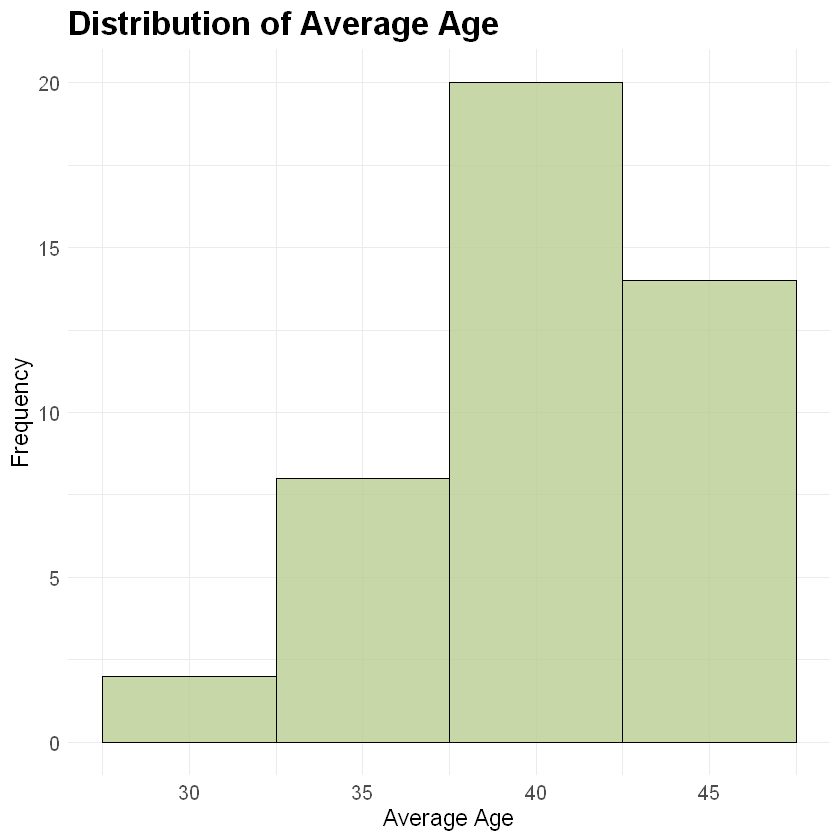

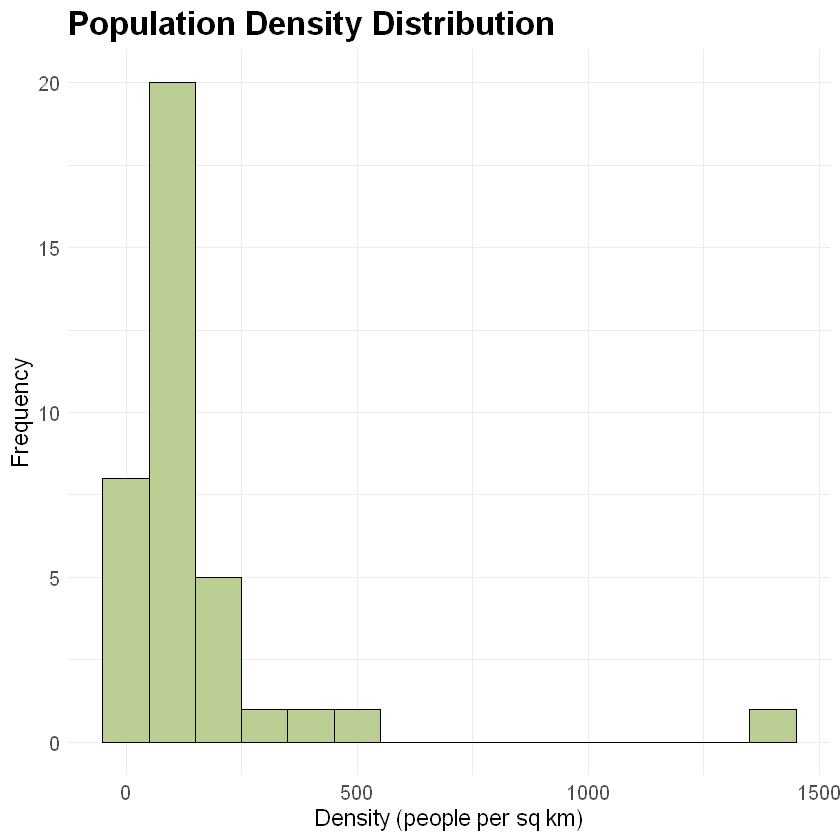

In [285]:
# Age histogram
ggplot(data_age, aes(x=values)) + 
  geom_histogram(binwidth=5, fill="#BACD92", color="black", alpha = 0.8) +
  labs(title = "Distribution of Average Age",
       x = "Average Age",
       y = "Frequency") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),  # Caption size and style
        axis.text = element_text(size = 12),  # Text size on axes
        axis.title = element_text(size = 14))  # Size of axis labels


# Density histogram
ggplot(data_density, aes(x=values)) + 
  geom_histogram(binwidth=100, fill="#BACD92", color="black") +  
  labs(title = "Population Density Distribution",
       x = "Density (people per sq km)",
       y = "Frequency") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),  # Caption size and style
        axis.text = element_text(size = 12),  # Text size on axes
        axis.title = element_text(size = 14))  # Size of axis labels

Na histogramu distribuce průměrného věku vidíme, že největší počet zemí má průměrný věk obyvatelstva kolem 40 let, zatímco distribuce hustoty zalidnění ukazuje, že většina zemí má nízkou hustotu zalidnění, s několika zeměmi výrazně odlišnými s velmi vysokou hustotou.

In [286]:
# Rename
data_age_renamed <- data_age %>% rename(age = values)
data_density_renamed <- data_density %>% rename(density = values)

# Join
combined_data <- left_join(data_age_renamed, data_density_renamed, by = "geo")

# Correlation
correlation_result <- cor(combined_data$age, combined_data$density, use = "complete.obs")
print(correlation_result)

[1] 0.07637682


Korelace ve výši 0,07637682 ukazuje velmi slabou pozitivní souvislost mezi průměrným věkem a hustotou zalidnění. To znamená, že vztah mezi těmito dvěma proměnnými je téměř zanedbatelný a není významným faktorem ve většině ekonomických modelů.

In [287]:
data_hdp_renamed <- data %>% rename(hdp = values)

In [288]:
data1 <- merge(data_hdp_renamed, data_age_renamed, by = "geo")
data2 <- merge(data1, data_density_renamed, by = "geo")

In [289]:
head(data2)

,geo,hdp,age,density
,<chr>,<dbl>,<dbl>,<dbl>
1,Albania,3560,34.7,100.1
2,Austria,39890,43.0,104.9
3,Belgium,36960,41.4,371.8
4,Bulgaria,6380,43.4,66.2
5,Croatia,10810,42.8,74.4
6,Cyprus,21170,37.0,92.0


#### ✦ Jazyk a měna

In [290]:
# Loading data from a CSV file
world_data <- read.csv("world-data-2023.csv", header = TRUE, sep = ",", quote = "\"", dec = ".", fill = TRUE, na.strings = c("", "NA"))

head(world_data)

,Country,Density..P.Km2.,Abbreviation,Agricultural.Land....,Land.Area.Km2.,Armed.Forces.size,Birth.Rate,Calling.Code,Capital.Major.City,Co2.Emissions,⋯,Out.of.pocket.health.expenditure,Physicians.per.thousand,Population,Population..Labor.force.participation....,Tax.revenue....,Total.tax.rate,Unemployment.rate,Urban_population,Latitude,Longitude
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93,Kabul,"8,672",⋯,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.93911,67.709953
2,Albania,105,AL,43.10%,"28,748","9,000",11.78,355,Tirana,"4,536",⋯,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.15333,20.168331
3,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213,Algiers,"150,006",⋯,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.03389,1.659626
4,Andorra,164,AD,40.00%,468,NA,7.20,376,Andorra la Vella,469,⋯,36.40%,3.33,"77,142",NA,NA,NA,NA,"67,873",42.50628,1.521801
5,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244,Luanda,"34,693",⋯,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.20269,17.873887
6,Antigua and Barbuda,223,AG,20.50%,443,0,15.33,1,"St. John's, Saint John",557,⋯,24.30%,2.76,"97,118",NA,16.50%,43.00%,NA,"23,800",17.06082,-61.796428


In [291]:
colnames(world_data)

[1] "Country"                                  
 [2] "Density..P.Km2."                          
 [3] "Abbreviation"                             
 [4] "Agricultural.Land...."                    
 [5] "Land.Area.Km2."                           
 [6] "Armed.Forces.size"                        
 [7] "Birth.Rate"                               
 [8] "Calling.Code"                             
 [9] "Capital.Major.City"                       
[10] "Co2.Emissions"                            
[11] "CPI"                                      
[12] "CPI.Change...."                           
[13] "Currency.Code"                            
[14] "Fertility.Rate"                           
[15] "Forested.Area...."                        
[16] "Gasoline.Price"                           
[17] "GDP"                                      
[18] "Gross.primary.education.enrollment...."   
[19] "Gross.tertiary.education.enrollment...."  
[20] "Infant.mortality"                         
[21] "Largest.city"                             
[22] "Life.expectancy"                          
[23] "Maternal.mortality.ratio"                 
[24] "Minimum.wage"                             
[25] "Official.language"                        
[26] "Out.of.pocket.health.expenditure"         
[27] "Physicians.per.thousand"                  
[28] "Population"                               
[29] "Population..Labor.force.participation...."
[30] "Tax.revenue...."                          
[31] "Total.tax.rate"                           
[32] "Unemployment.rate"                        
[33] "Urban_population"                         
[34] "Latitude"                                 
[35] "Longitude"

In [292]:
data_language <- world_data %>% select(Country, Official.language) 

ERROR: Error in select(., Country, Official.language): unused arguments (Country, Official.language)


In [ ]:
data_language_renamed <- data_language %>% rename(geo = Country, language = Official.language)

In [ ]:
data_currency <- world_data %>% select(Country, Currency.Code) 

In [ ]:
data_currency_renamed <- data_currency %>% rename(geo = Country, currency = Currency.Code)

In [ ]:
summary(data_language_renamed)

In [ ]:
summary(data_currency_renamed)

In [ ]:
data3 <- merge(data_hdp_renamed, data_language_renamed, by = "geo")
data4 <- merge(data3, data_currency_renamed, by = "geo")

In [ ]:
head(data4)

In [ ]:
#  1 - German, 0 - anything else
data4$language_cat <- ifelse(data4$language == "German", 1, 0)

# 1 - EUR, 0 - anything else
data4$currency_cat <- ifelse(data4$currency == "EUR", 1, 0)

print(head(data4))

In [ ]:
data4$currency_cat[is.na(data4$currency_cat)] <- 0

In [ ]:
library(ggplot2)
library(dplyr)

# Create new categories for labels
data4 <- data4 %>%
  mutate(language_label = ifelse(language_cat == 1, "German", "Else"),
         currency_label = ifelse(currency_cat == 1, "EUR", "Else"))

# Summarize data for language pie chart
language_counts <- data4 %>%
  count(language_label) %>%
  mutate(percentage = n / sum(n) * 100,
         label = paste0(language_label, " (", round(percentage, 1), "%)"))

# Define custom colors for languages
language_colors <- c("German"="#FCFFE0", "Else"="#FFA500")
# Update names based on your labels
language_colors <- setNames(language_colors[names(language_colors)], language_counts$label)

# Language pie chart
ggplot(language_counts, aes(x = "", y = n, fill = label)) +
  geom_bar(width = 1, stat = "identity", color = "black") +
  coord_polar(theta = "y") +
  labs(title = "Distribution of Languages") +
  theme_minimal() +
  theme(axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        plot.title = element_text(size = 20, face = "bold"),
        legend.title = element_blank(),
        legend.text = element_text(size = 12)) +
  scale_fill_manual(values = language_colors) # Custom colors

# Summarize data for currency pie chart
currency_counts <- data4 %>%
  count(currency_label) %>%
  mutate(percentage = n / sum(n) * 100,
         label = paste0(currency_label, " (", round(percentage, 1), "%)"))

# Define custom colors for currencies
currency_colors <- c("EUR"="#FCFFE0", "Else"="#FFA500")
# Update names based on labels
currency_colors <- setNames(currency_colors[names(currency_colors)], currency_counts$label)

# Currency pie chart
ggplot(currency_counts, aes(x = "", y = n, fill = label)) +
  geom_bar(width = 1, stat = "identity", color = "black") +
  coord_polar(theta = "y") +
  labs(title = "Distribution of Currencies") +
  theme_minimal() +
  theme(axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        plot.title = element_text(size = 20, face = "bold"),
        legend.title = element_blank(),
        legend.text = element_text(size = 12)) +
  scale_fill_manual(values = currency_colors) # Custom colors

In [ ]:
table_language_currency <- table(data4$language, data4$currency)

# Fisher's test
fisher_test <- fisher.test(table_language_currency)
print(fisher_test)

Výsledky Fisherova přesného testu s p-hodnotou 1.375e-11 ukazují, že mezi jazykem a měnou existuje statisticky významná závislost.

## ✭ Úloha 3

Pomocí lineárního regresního modelu zkoumejme závislost HDP na všech regresorech.

### ✦ Průměrný věk a hustota zalidnění

In [ ]:
model1 <- lm(hdp ~ age + density, data = data2)
summary(model1)

#### ❀ Interpretace hodnot odhadů regresních koeficientů
**Intercept** představuje odhadovanou střední hodnotu závislé proměnné (hdp), pokud jsou všechny nezávislé proměnné (age a density) nulové. V tomto případě je intercept -17192,40, ale není statisticky významný, protože p-hodnota (0,794) je větší než zvolená hladina významnosti (např. 0,05). Proto není vhodné interpretovat intercept v tomto modelu.

**Age** má koeficient 1120,52. To znamená, že při zachování ostatních proměnných se s každou jednotkou zvýšení věku odhadovaná hodnota hdp zvýší o 1120,52 jednotky. Koeficient však není statisticky významný (p-hodnota = 0,489 > 0,05), což naznačuje, že věk nemá v tomto modelu významný lineární vztah s hdp.

**Density** má koeficient 13.14. To znamená, že při zachování ostatních proměnných se při každém jednotkovém zvýšení hustoty odhadovaná hodnota hdp zvýší o 13,14 jednotky. Podobně jako u proměnné věk není koeficient pro hustotu statisticky významný (p-hodnota = 0,533 > 0,05), což naznačuje, že hustota nemusí mít v tomto modelu významný lineární vztah s hdp.

#### ❀ Kvalita modelu
První model je regrese založená na HDP a věku/hustotě zalidnění. Koeficient determinace (Multiple R-squared) je 0,02827, což je hodnota blízká nule; to znamená, že pouze 2,83 % rozptylu závislé proměnné (HDP) je vysvětleno nezávislými proměnnými (věk a hustota). V nejhorším případě bude mít model 𝑅2 = 0, a nejsme od toho daleko. Adjustovaný koeficient determinace je ještě nižší a činí -0,03063 (jeho hodnota bude vždy menší nebo rovna hodnotě 𝑅2). Hodnota menší než 0 opět znamená, že model nemá žádnou vypovídací hodnotu.

F-statistika testuje celkovou významnost regresního modelu. Hodnota F-statistiky se porovnává s prahovou hodnotou, která je odvozena z F-rozdělení. Výsledek testu se zjišťuje pomocí p-hodnoty, která je v našém případě 0.623, což je vyšší než běžná hladina významnosti 0.05. To znamená, že nemáme dostatečné statistické důkazy k závěru, že alespoň jedna z nezávislých proměnných má statisticky významný vliv na závislou proměnnou. Takže F-statistika není statisticky významná a regresní model jako celek taky není významný.

#### ❀ Analýza reziduí

Zajímájí nás především **průměr reziduí** (ideálně hodnota okolo nuly) a **normalita reziduí** (pomocí testu normality).

In [ ]:
# Histogram of residuals
ggplot(data = data.frame(residuals = resid(model1)), aes(x = residuals)) +
  geom_histogram(binwidth=10000, fill = "#BACD92", color = "black") +
  labs(title = "Histogram of Residuals",
       x = "Residuals",
       y = "Frequency") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

# Q-Q plot of residuals
ggplot(data = data.frame(residuals = resid(model1)), aes(sample = residuals)) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "Q-Q Plot of Residuals",
       x = "Theoretical Quantiles",
       y = "Sample Quantiles") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

# Plot of residuals vs fitted values
ggplot(data = data.frame(fitted_values = fitted(model1), residuals = resid(model1)), 
                              aes(x = fitted_values, y = residuals)) +
  geom_point(fill = "#FCFFE0", color = "black") +
  labs(title = "Residuals vs Fitted Values",
       x = "Fitted Values",
       y = "Residuals") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

In [ ]:
# Calculate mean of residuals
mean_residuals <- mean(resid(model1))
print(mean_residuals)

# Normality of residuals: Shapiro-Wilk test
shapiro_test <- shapiro.test(resid(model1))
normality <- ifelse(shapiro_test$p.value >= 0.05, "Normally distributed", "Not normally distributed")
print(normality)

Průměr reziduí je hodnota velmi blízká nule, což znamená, že rezidua jsou v průměru soustředěna kolem nuly, což je pro rezidua lineárního regresního modelu žádoucí vlastnost.

Výsledky Shapiro-Wilkova testu ukazují, že p-hodnota je nižší než hladina významnosti 0,05. Proto zamítáme nulovou hypotézu o normalitě, což znamená, že rezidua nejsou normálně rozdělena.

#### ❀ Odlehlá pozorování a multikolinearita

Odlehlé hodnoty identifikujeme pomocí Cookovy vzdálenosti. Multikolinearitu zkoumáme pomocí VIF a korelační matice.

In [ ]:
# Identify outliers
# Residual Analysis
plot(fitted(model1), resid(model1), main = "Residuals vs Fitted Values", xlab = "Fitted Values", ylab = "Residuals")

# Leverage-Residual plot
plot(hatvalues(model1), rstandard(model1), main = "Leverage vs Standardized Residuals", xlab = "Leverage", ylab = "Standardized Residuals")

# Cook's distance
cooks_dist <- cooks.distance(model1)
plot(cooks_dist, pch = 19, main = "Cook's Distance", xlab = "Observation", ylab = "Cook's Distance")
abline(h = 4/length(cooks_dist), col = "red")  # Highlight a threshold for influential observations

In [ ]:
# Explore multicollinearity using VIF
vif_values <- vif(model1)
print("VIF values:")
print(vif_values)

# Correlation matrix
correlation_matrix <- cor(data2[, c("age", "density")])
print("Correlation Matrix:")
print(correlation_matrix)

**VIF (Variance Inflation Factor)**  je míra používaná ke zjištění přítomnosti a závažnosti multikolinearity v regresní analýze. K multikolinearitě dochází, když jsou dvě nebo více predikčních proměnných v regresním modelu vysoce korelované, což znamená, že jednu predikční proměnnou lze lineárně předpovědět z ostatních se značnou mírou přesnosti. To může způsobit problémy, protože to oslabuje statistickou významnost predikčních proměnných. V našem případě jsou hodnoty VIF pro "age" i "density" přibližně 1. To znamená, že mezi těmito predikčními proměnnými neexistuje významná multikolinearita.

**Korelační matice** ukazuje párové korelační koeficienty mezi predikčními proměnnými. Korelační koeficient 1 nebo -1 znamená dokonalou pozitivní, resp. negativní korelaci. Korelační koeficient blízký 0 naznačuje, že mezi proměnnými neexistuje lineární korelace.
V našem výstupu není k dispozici korelační koeficient mezi "age" a "density" (NA). To znamená, že mezi těmito dvěma proměnnými neexistuje žádná korelace.

Otestujeme předpoklady modelu - pokud nebudou splněny, vyvíjíme a otestujeme metody, které toto selhání kompenzují nebo předpoklady odstraňují. Na to použijeme ANOVA test rozptylu. Stanovíme příslušné hypotézy.

**● Proměnná "age"**

$H_0:$ Koeficient proměnné "age" v regresním modelu je roven nule.

$H_A:$ Koeficient proměnné "age" v regresním modelu není roven nule (což naznačuje významný vliv na závislou proměnnou).

**● Proměnná "density"**

$H_0:$ Koeficient proměnné "density" v regresním modelu je roven nule.

$H_A:$ Koeficient proměnné "density" v regresním modelu není roven nule (což naznačuje významný vliv na závislou proměnnou).

In [ ]:
# Fit the linear regression model
model1 <- lm(hdp ~ age + density, data = data2)

# Perform ANOVA test
anova_result <- anova(model1)

# Print ANOVA table
print(anova_result)

Na základě výsledků ANOVA vyvozujeme závěry.

Proměnná "age": p-hodnota (0,4581) je vyšší než zvolená hladina významnosti (0,05). Nulovou hypotézu pro „věk“ tedy nezamítáme. Není dostatek důkazů pro závěr, že věk má významný vliv na HDP.

Proměnná "density": p-hodnota (0.5333) je opět vyšší než zvolená hladina významnosti. Proto nezamítáme nulovou hypotézu ani pro hustotu. Neexistuje dostatek důkazů pro závěr, že hustota má významný vliv na HDP.

Na základě výsledků testu ANOVA se zdá, že ani věk, ani hustota zalidnění nejsou významnými prediktory HDP v tomto regresním modelu.

Nyní nakreslíme grafy, které odhalí vztah mezi závislou proměnnou HDP a proměnnými age/density.

In [ ]:
# HDP/Age
ggplot(data2, aes(x = age, y = hdp)) +
  geom_point() +
  geom_smooth(method = "lm", col = "#75A47F") +
  labs(title = "Relationship between HDP and age",
       x = "Average age of the population",
       y = "HDP") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),  # Caption size and style
        axis.text = element_text(size = 12),  # Text size on axes
        axis.title = element_text(size = 14),  # Size of axis labels
        axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate and align x-axis labels

# HDP/Density
ggplot(data2, aes(x = density, y = hdp)) +
  geom_point() +
  geom_smooth(method = "lm", col = "#75A47F") +
  labs(title = "Relationship between HDP and density",
       x = "Density",
       y = "HDP") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),  # Caption size and style
        axis.text = element_text(size = 12),  # Text size on axes
        axis.title = element_text(size = 14),  # Size of axis labels
        axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate and align x-axis labels

Grafy ukazují, že i když existuje pozitivní trend mezi průměrným věkem obyvatelstva a HDP, a negativní trend mezi hustotou obyvatelstva a HDP, oba tyto vztahy nejsou statisticky významné, což potvrzují analýzy regresních modelů.

### ✦ Jazyk a měna

U kategoriální a spojité proměnné lze multikolinearitu měřit pomocí t-testu (pokud má kategoriální proměnná 2 kategorie) nebo ANOVA (pokud má více než 2 kategorie). ANOVA test stejně potřebujeme při zkoumání hypotéz, takže pustíme se do toho.

In [ ]:
model2 <- lm(hdp ~ language_cat + currency_cat, data = data4)
summary(model2)

#### ❀ Interpretace hodnot odhadů regresních koeficientů
**Intercept** má hodnotu 28,472, což je statisticky významné, protože p-hodnota je 9.08e-05, což je mnohem nižší než obvyklá hladina významnosti 0.05. To naznačuje, že průměrná hodnota závislé proměnné je statisticky odlišná od nuly, když jsou všechny nezávislé proměnné nulové.

**Regresní koeficienty pro jazyk (Language)** , který činí 50,194, naznačuje, že HDP je statisticky významně vyšší pro kategorie označené jako language_cat. Vysoká statistická významnost tohoto koeficientu, podpořená p-hodnotou 0.000767, ukazuje na silný vliv jazyka na HDP v těchto kategoriích.

**Regresní koeficienty pro měnu (Currency)** je -6,878, což signalizuje, že HDP je nižší pro kategorie pod currency_cat. Avšak s p-hodnotou 0.429333 tento koeficient není statisticky významný, což naznačuje, že vliv měny na HDP není statisticky podložený a může být ovlivněn jinými faktory nebo šumem v datech.

#### ❀ Kvalita modelu
Model regresní analýzy, zkoumající vztah mezi HDP a proměnnými language_cat a currency_cat, vykazuje koeficient determinace R2=0,3123R2=0,3123, což znamená, že model vysvětluje přibližně 31.23% variability závislé proměnné HDP. Nicméně, upravený koeficient determinace, který bere v úvahu počet prediktorů a velikost vzorku, je pouze 0,2693. Toto relativně nízké číslo může naznačovat, že přidané prediktory nepřispívají významně k vysvětlení variability HDP a model může být přeučený.

F-statistika, která testuje celkovou významnost modelu, má hodnotu 7.265 na 2 a 32 stupních volnosti s p-hodnotou 0.002504. Ačkoliv tato p-hodnota naznačuje, že model jako celek má statisticky významný přínos k vysvětlení variability HDP, je třeba být opatrný vzhledem k nízkému upravenému R2R2 a potenciálnímu přeučení. Rozdíly v p-hodnotách mezi F-statistikou a individuálními koeficienty také ukazují na možnou nekonzistenci ve významnosti jednotlivých prediktorů ve srovnání s celkovým modelem.

#### ❀ Analýza reziduí

Analyzujeme stejná kritéria jako v prvním modelu.

In [ ]:
# Histogram of residuals
ggplot(data = data.frame(residuals = resid(model2)), aes(x = residuals)) +
  geom_histogram(binwidth = 10000, fill = "#BACD92", color = "black") +
  labs(title = "Histogram of Residuals",
       x = "Residuals",
       y = "Frequency") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

# Q-Q plot of residuals
ggplot(data = data.frame(residuals = resid(model2)), aes(sample = residuals)) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "Q-Q Plot of Residuals",
       x = "Theoretical Quantiles",
       y = "Sample Quantiles") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

# Plot of residuals vs fitted values
ggplot(data = data.frame(fitted_values = fitted(model2), residuals = resid(model2)), 
                              aes(x = fitted_values, y = residuals)) +
  geom_point(fill = "#FCFFE0", color = "black") +
  labs(title = "Residuals vs Fitted Values",
       x = "Fitted Values",
       y = "Residuals") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

In [ ]:
# Calculate mean of residuals
mean_residuals <- mean(resid(model2))
print(mean_residuals)

# Normality of residuals: Shapiro-Wilk test
shapiro_test <- shapiro.test(resid(model2))
normality <- ifelse(shapiro_test$p.value >= 0.05, "Normally distributed", "Not normally distributed")
print(normality)

Průměr reziduí v našem modelu je přibližně 2.333118e-13, což je velmi blízko nule. To naznačuje, že v průměru jsou rezidua soustředěna kolem nuly, což je obecně dobré znamení v regresní analýze, jelikož ukazuje, že model nemá systematickou chybu ve svých predikcích.

Nicméně, výsledky Shapiro-Wilkova testu na normalitu reziduí ukazují, že p-hodnota je nižší než 0.05. Tento výsledek nás vede k zamítnutí nulové hypotézy o normalitě rozdělení reziduí. Dospíváme tedy k závěru, že rezidua nejsou normálně rozdělena, což může mít dopad na výsledky některých statistických testů, které předpokládají normalitu reziduí pro plnou validitu svých inferencí.

#### ❀ Odlehlá pozorování a multikolinearita

Analogicky jako v prvním modelu.

In [ ]:
# Identify outliers
# Residual Analysis
plot(fitted(model2), resid(model2), main = "Residuals vs Fitted Values", xlab = "Fitted Values", ylab = "Residuals")

# Leverage-Residual plot
plot(hatvalues(model2), rstandard(model2), main = "Leverage vs Standardized Residuals", xlab = "Leverage", ylab = "Standardized Residuals")

# Cook's distance
cooks_dist <- cooks.distance(model2)
plot(cooks_dist, pch = 19, main = "Cook's Distance", xlab = "Observation", ylab = "Cook's Distance")
abline(h = 4/length(cooks_dist), col = "#75A47F")  # Highlight a threshold for influential observations

In [ ]:
# Explore multicollinearity

# Correlation matrix
cor_matrix <- cor(data4[c("language_cat", "currency_cat")])
print(cor_matrix)

In [ ]:
# Fit the model
model2 <- lm(hdp ~ language_cat + currency_cat, data = data4)

# Calculate VIF
vif_values <- vif(model2)

# Interpretation
if(any(vif_values > 5)){
  print("Potential multicollinearity problem detected.")
} else {
  print("No significant multicollinearity detected.")
}

**VIF** v tomto případě leží v intervalu (1, 5), což znamená, že predikční proměnné jsou do jisté míry korelované, ale míra multikolinearity není natolik závažná, aby významně ovlivnila odhady regresních koeficientů.

**Korelační matice**  ukazuje, že neexistuje žádný významný lineární vztah mezi language_cat a currency_cat.

Otestujeme předpoklady modelu pomoci ANOVA testu. Stanovíme příslušné hypotézy.

**● Proměnná "language"**

$H_0:$ Proměnná "language" nemá významný vliv na proměnnou "HDP".

$H_A:$ Alespoň jedna z kategorie proměnné "language" má významný vliv na proměnnou "HDP".

**● Proměnná "currency"**

$H_0:$ Proměnná "currency" nemá významný vliv na proměnnou "HDP".

$H_A:$ Alespoň jedna z kategorie proměnné "currency" má významný vliv na proměnnou "HDP".

In [ ]:
# Perform ANOVA test
anova_result <- anova(model2)

# Print ANOVA table
print(anova_result)

Výsledky ANOVA testu ukazují následující:

Proměnná "language": p-hodnota je 0,4828, což je více než hladina významnosti 0,05. Nulovou hypotézu tedy nezamítáme. Z toho vyplývá, že kategorie jazyka nemají významný vliv na HDP.

Proměnná "currency": p-hodnota je 0.1091, která je yase větší než 0,05. Nulovou hypotézu tedy nezamítáme ani v případě měny. To znamená, že kategorie měny nemají na HDP žádný významný vliv.

A opět dva grafy, které ukazují vztah mezi HDP a (tentokrát) jazykem/měnou.

In [ ]:
# Box plot for HDP/language with separate categories
ggplot(data4, aes(x = factor(language_cat), y = hdp)) +
  geom_boxplot() +
  labs(title = "HDP vs Language Category",
       x = "Language Category (1 = German, 0 = Other)",
       y = "HDP") +
  theme_minimal()

**Medián HDP** v zemích, kde je hlavním jazykem němčina, je vyšší než medián HDP v zemích, kde hlavním jazykem není němčina.

**IQR (výška rámečku)** pro obě jazykové kategorie ukazuje rozpětí středních 50 % hodnot HDP. U neněmecky mluvících zemí je IQR užší, což ukazuje na menší variabilitu HDP. U německy mluvících zemí je IQR širší, což naznačuje větší variabilitu HDP mezi těmito zeměmi.

V neněmecky mluvících zemích je nápadná **odlehlá hodnota**, která představuje zemi s neobvykle vysokým HDP ve srovnání s ostatními zeměmi v této skupině. Skupina německy mluvících zemí nemá tak extrémní **odlehlé hodnoty**, což naznačuje větší konzistenci mezi vysokými hodnotami HDP.

Skupina německých zemí má celkově širší **distribuce** hodnot HDP ve srovnání se skupinou neněmeckých zemí. Horní whisker pro německé země se rozšiřuje výše, což znamená, že nejvýkonnější země v této skupině mají vyšší hodnoty HDP ve srovnání s nejvýkonnějšími zeměmi ve skupině neněmeckých zemí.

**Závěr**: v zemích, kde je němčina hlavním jazykem, jsou hodnoty HDP v průměru vyšší než v zemích, kde němčina hlavním jazykem není. Mezi německy mluvícími zeměmi je také větší variabilita hodnot HDP, což naznačuje širší škálu ekonomických podmínek v těchto zemích. Neněmecky mluvící země mají tendenci vykazovat konzistentnější, i když obecně nižší hodnoty HDP, s jednou výraznou odchylkou. Tato pozorování naznačují, že primární jazyk (ať už německý, nebo jiný) je spojen s rozdíly v hodnotách HDP, přičemž německy mluvící země mají obecně vyšší HDP, ale také vykazují větší variabilitu. To může být způsobeno různými socioekonomickými faktory specifickými pro německy mluvící země.

In [ ]:
# Box plot for HDP/currency with separate categories
ggplot(data4, aes(x = factor(currency_cat), y = hdp)) +
  geom_boxplot() +
  labs(title = "HDP vs Language Category",
       x = "Currency Category (1 = Euro, 0 = Other)",
       y = "HDP") +
  theme_minimal()

**Medián HDP** je vyšší v zemích používajících euro ve srovnání se zeměmi používajícími jiné měny.

**IQR (výška rámečku)** je užší u zemí platících eurem, což naznačuje menší variabilitu HDP mezi těmito zeměmi ve srovnání s ostatními.

V obou kategoriích se vyskytují výrazné **odlehlé hodnoty**, zejména však mezi zeměmi nepoužívajícími euro, což naznačuje, že některé země mají mimořádně vysoké hodnoty HDP.

HDP v zemích, které nepoužívají euro, se pohybuje v širším **rozmezí**, což naznačuje větší rozdíly v ekonomických podmínkách mezi těmito zeměmi.

**Závěr**: Země používající euro mají tendenci vykazovat vyšší a konzistentnější hodnoty HDP ve srovnání se zeměmi používajícími jiné měny. To znamená, že země eurozóny mají jednotnější ekonomické podmínky, zatímco země s jinými měnami vykazují různorodější ekonomickou výkonnost.

Nyní se pokusíme najít finální model, který chování HDP dobře vysvětluje, ale neobsahuje nevýznamné komponenty.

### ⚘ Výběr finálního modelu

In [ ]:
str(data4)

In [ ]:
str(data2)

In [ ]:
# Merge datasets based on 'geo' and 'hdp' columns
merged_data <- merge(data4, data2, by = c("geo", "hdp"), all = TRUE)

In [ ]:
str(merged_data)

In [ ]:
any_na <- any(is.na(merged_data))
print(any_na)

In [ ]:
# Identifying missing values
missing_values <- is.na(merged_data)

# Display rows with missing values
rows_with_missing <- merged_data[apply(missing_values, 1, any), ]
print(rows_with_missing)

In [ ]:
# Fitting the model with all regressors
fit_all <- lm(hdp ~ age + density + language_cat + currency_cat, data=merged_data)

# Model summary
summary(fit_all)

Z výsledků modelu můžeme vidět, které regresory jsou statisticky významné a které ne.

Statisticky významné regresory:

**language_cat**: p-hodnota je rovna 0,00189, což je menší než zvolená hladina významnosti 0,01.

Nevýznamné regresory:

**intercept**: je roven 48784,76, ale není statisticky významný (p-hodnota = 0,55227), což znamená, že základní HDP (když jsou všechny prediktory nulové) se významně neliší od nuly.

**age**: koeficient pro věk je -543,46 s p-hodnotou 0,78958, což znamená, že věk není významným prediktorem HDP.

**density**: koeficient hustoty je 13,53 s p-hodnotou 0,47137, což znamená, že hustota není rovněž významným prediktorem HDP.

**currency_cat**: koeficient pro currency_cat je -7168,74 s p-hodnotou 0,46165, což znamená, že kategorie měny není statisticky významným prediktorem HDP.

Nevýznamnost musíme interpretovat z hlediska každého z regresorů zvlášť.

Nejdříve vybereme nejméně signifikantní proměnnou z původního modelu. V našem případě, když se podíváme na p-hodnoty, můžeme vidět, že nejméně významnou proměnnou je "age" (má největší p-hodnotu).

In [ ]:
fit_all_exc_age <- lm(hdp ~ density + language_cat + currency_cat, data=merged_data)

# Model summary
summary(fit_all_exc_age)

Koeficient determinace (Multiple R-squared) je 0.3297,
adjustovaný koeficient determinace (Adjusted R-squared) je 0.2604.

Porovnáme s koeficienty determinace původního modelu:

In [ ]:
summary(fit_all)$r.squared
summary(fit_all)$adj.r.squared

Odstranění nejméně významné proměnné (věk) z modelu vedlo k nepatrnému snížení R-kvadrátu, ale k mírnému zvýšení upraveného R-kvadrátu, což ukazuje na efektivnější model bez zbytečných prediktorů. Oba modely však stále vykazují poměrně nízký koeficient determinace. Podobnou analýzu můžeme provést i pro zbývající regresory a zjistit, zda jejich odstranění povede k dalšímu zlepšení modelu.

In [ ]:
# Density is the worst in this case with p-value = 0.553648
fit_all_exc_density <- lm(hdp ~ language_cat + currency_cat, data=merged_data)

# Model summary
summary(fit_all_exc_density)

Aktualizovaný model (s vyloučením hustoty) je lepší z hlediska upraveného R-kvadrátu, i když celkový vysvětlený rozptyl (R-kvadrát) je o něco nižší. To znamená, že hustota nepřispívala k užitečným informacím a její odstranění vedlo k robustnějšímu modelu. Zkusíme odebrat proměnnou currency_cat.

In [ ]:
fit_all_exc_currency <- lm(hdp ~ language_cat, data=merged_data)

# Model summary
summary(fit_all_exc_currency)

Porovnáme s koeficienty determinace původního modelu fit_all. Odstranění dalšího regresoru opět vedlo ke zlepšení upraveného koeficientu determinace, což znamená, že nový model o něco lépe vysvětluje variabilitu dat než původní. Ačkoli je však upravený koeficient determinace vyšší, stále zůstává relativně nízký, což vede k tomu, že model stále není schopen plně vysvětlit veškerou variabilitu v datech.

### ⚘ Model vs. podmodel

Testujeme, zda jsme schopny redukovat původní model na nějaký podmodel. Zkoumáme tedy, zda je rozdíl reziduálních součtů čtverců významně velký, tj. zda širší model vnáší do dat více variability, než je nezbytně nutné k vysvětlení pozorované variability.

Protože fit_all_exc_currency je jednodušší, je podmodelem fit_all. V našem případě se však fit_all_exc_currency jeví jako restriktivnější model (vypadává příliš mnoho proměnných). Nemůžeme je tedy přímo porovnat pomocí ANOVA. Místo toho budeme porovnávat jejich hodnoty AIC (Akaikeho informační kritérium) a BIC (Bayesovo informační kritérium).

In [ ]:
# Compare models using AIC
AIC(fit_all, fit_all_exc_age, fit_all_exc_density, fit_all_exc_currency)

# Compare models using BIC
BIC(fit_all, fit_all_exc_age, fit_all_exc_density, fit_all_exc_currency)

Na základě hodnot AIC a BIC má fit_all přednost před fit_all_exc_currency, protože poskytuje lepší kompromis mezi vhodností a složitostí modelu, což naznačuje lepší celkový model (nižší hodnota AIC nebo BIC znamená šikovnější model).

Nakonec můžeme použít nějaký automatický optimalizátor k nalezení nejlepšího modelu. Například pomocí knihovny glmulti.

In [ ]:
# Load the glmulti package
library(glmulti)

# Fit models with all possible combinations of predictors
models <- glmulti(hdp ~ age + density + language_cat + currency_cat, data = merged_data, level = 1)

# Print result
print(models)

Pro fitování modelu jsme použili metodu vyčerpávajícího vyhledávání (exhaustive search) a pro výběr modelu kritérium AIC. Úroveň 1 znamená, že při vyčerpávajícím hledání byly zvažovány všechny možné kombinace prediktorů bez zohlednění interakcí nebo členů vyššího řádu.

Nejlepší model je "hdp ~ 1 + age + density + language_cat" s AIC = 745,737735166038. Váha důkazu (šance, že tento model je nejlepším modelem ze souboru kandidátů) nejlepšího modelu je přibližně 66 %.

Můžeme vykreslit všechny modely s jejich hodnotami AIC.

In [ ]:
plot(models)

Vodorovná červená čára rozlišuje modely, jejichž hodnota AIC je menší nebo větší než 2 jednotky od hodnoty „nejlepšího“ modelu (tj. modelu s nejnižší hodnotou AIC). Výše uvedený výstup ukazuje, že existují 2 takové modely. Vypíšeme je.

In [ ]:
top <- weightable(models)
top <- top[top$aic <= min(top$aic) + 2,]
top

In [ ]:
# Retrieve the best model
summary(models@objects[[1]])

Popišme a interpretujme nejlepší model.

#### ⊹ Koeficienty

(Intercept): intercept je 62 751,45 s vysokou standardní chybou 78 240,54, což naznačuje vysokou nejistotu tohoto odhadu. p-hodnota je 0,42929, což není významné.

age: koeficient je -981,04, což naznačuje negativní vztah k hdp; p-hodnota je však 0,61230, což není významné.

density: koeficient je 12,33, což naznačuje pozitivní vztah k hdp; p-hodnota je však 0,50606, což není významné.

language_cat: koeficient je 52 754,29, což ukazuje na silný pozitivní vztah s hdp. p-hodnota je 0,00112, takže tento prediktor je statisticky významný na 1% hladině (**).

#### ⊹ Statistiky přizpůsobení modelu

Parametr rozptylu: U Gaussovy rodiny je to rozptyl reziduí, který udává variabilitu odezvy, která není vysvětlena modelem.

Nulová odchylka: 2,7476e+10 na 31 stupních volnosti. Tím se měří celková variabilita proměnné odpovědi hdp.

Reziduální odchylka: 1,8109e+10 na 28 stupních volnosti. Tím se měří variabilita proměnné odezvy, která zůstává modelem nevysvětlena.

AIC: 745.74. Jedná se o Akaikeho informační kritérium, což je míra vhodnosti modelu penalizovaná počtem parametrů. Nižší hodnoty ukazují na lepší model.

Počet iterací Fisherova bodování: 2. Tento údaj udává počet iterací, které algoritmus fitování potřeboval ke konvergenci.

#### ⊹ Interpretace a závěr

Nejlepší model zahrnuje věk, hustotu a jazyk_cat jako prediktory hdp.

Jazyk_cat je jediným statisticky významným prediktorem, což naznačuje silný pozitivní vztah k hdp.

Věk ani hustota nejsou v tomto modelu statisticky významnými prediktory.

Poměrně vysoká hodnota AIC naznačuje, že ačkoli je tento model mezi uvažovanými nejlepší, může být ještě co zlepšovat.